### Troll Tweet Analysis

In this project, we will analyze Russian troll tweet data from the dataset provided by [fivethirtyeight](https://github.com/fivethirtyeight/russian-troll-tweets/).  
[Some analysis](http://pwarren.people.clemson.edu/Linvill_Warren_TrollFactory.pdf) of this data has already been completed and published by Linvill and Warren of Clemson university.

In this analysis, we will be trying to answer one primary question:  
**What characteristics of troll accounts and their tweets make them successful?**

In this case, we are equating success to the number of followers the troll account has, as a higher follower account will allow the troll to spread their message to a greater number of individuals. 

As we answer this question, we will be answering some secondary questions that will help guide our answer, such as:
* Which account category is most successful?
* What are some specific characteristics of the most successful account category?
* What are some of the most repeated words by the top troll accounts?

### Setup (run once):

This setup will get us to a clean DataFrame with which we will do further analysis and create visualizations with.  
This process only needs to be run all the way through one time in order to save a DataFrame with the data we need.

We will start off with some data cleaning and preparation.

In [1]:
import numpy as np
import pandas as pd
from textblob import TextBlob

Note that this CSV is not in this repository due to its size (1 GB+), but it is available from the [fivethirtyeight repository](https://github.com/fivethirtyeight/russian-troll-tweets/). 

In [20]:
df = pd.read_csv('all_tweets.csv', low_memory=False)#.drop(columns=['harvested_date', 'new_june_2018'])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2984389 entries, 0 to 2984388
Data columns (total 15 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   external_author_id  object
 1   author              object
 2   content             object
 3   region              object
 4   language            object
 5   publish_date        object
 6   harvested_date      object
 7   following           object
 8   followers           object
 9   updates             object
 10  post_type           object
 11  account_type        object
 12  new_june_2018       object
 13  retweet             object
 14  account_category    object
dtypes: object(15)
memory usage: 341.5+ MB


We can see that there are just under 3 million rows and 15 columns.

We won't be making use of the 'harvested_date' or 'new_june_2018' columns, so we will drop them.

In [22]:
df.drop(columns=['harvested_date', 'new_june_2018'], inplace=True)

In [23]:
df.head(3)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category
0,2535564756.0,1D_NICOLE_,#FoodPoisoning is not a joke! #Walmart #KochFa...,United States,English,11/26/2015 22:20,48,40,394,RETWEET,Koch,1,Fearmonger
1,2535564756.0,1D_NICOLE_,Thanks God that #turkey i ate few days ago was...,United States,English,11/26/2015 22:35,48,40,395,RETWEET,Koch,1,Fearmonger
2,2535564756.0,1D_NICOLE_,"who's got the worst make up ever, don't tell m...",United States,English,5/25/2015 12:38,59,51,352,NaN,Koch,0,Fearmonger


We can see that we get we get the actual tweet text in the 'content' column, as well as some other Twitter information, such as author, following, etc. 

Interestingly, there is also an 'account_category' column, which identifies what type of activity the troll account is performing, which we will analyze later. 

It is also worth noting that the 'retweet' column is **not** a count of retweets for any one tweet, but rather a binary value of whether or not the tweet is a retweet made by the troll account (1 = retweet, 0 = not a retweet).

In [24]:
df.account_category.value_counts()

NonEnglish          837725
RightTroll          719087
NewsFeed            599294
LeftTroll           427811
HashtagGamer        241827
Commercial          122582
Fearmonger           22141
Unknown              13905
account_category        17
Name: account_category, dtype: int64

We can see that 'NonEnglish' troll accounts weren't placed into a specific category, so we will drop those rows later. 

We can also see that there is quite the diversity with the account categories, though there seems to be some erroneous data where the listed account_category is 'account_category' in 17 rows.  
We can filter those out to avoid working with bad data. 

In [25]:
df = df[df.account_category != 'account_category']

In [27]:
df.dtypes

external_author_id    object
author                object
content               object
region                object
language              object
publish_date          object
following             object
followers             object
updates               object
post_type             object
account_type          object
retweet               object
account_category      object
dtype: object

We should also change the data types of some of the columns we will do further analysis on so that they will be compatible with the functions that we use. 

In [10]:
df = df.astype({'external_author_id': np.float64,
                'following':          np.int64,
                'followers':          np.int64,
                'retweet':            np.int64,
                'content':            'str',
                'account_category':   'str'})

Since we have tweet content, it may be interesting to take a look at a sentiment analysis of the data to gather more dimensions of the data.  
Sentiment analysis is best done with English tweets, so we will remove any non-English tweets.

In [39]:
df = df[(df.region == 'United States') & (df.language == "English")]

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1860606 entries, 0 to 2984171
Data columns (total 13 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   external_author_id  object
 1   author              object
 2   content             object
 3   region              object
 4   language            object
 5   publish_date        object
 6   following           object
 7   followers           object
 8   updates             object
 9   post_type           object
 10  account_type        object
 11  retweet             object
 12  account_category    object
dtypes: object(13)
memory usage: 198.7+ MB


This cuts the data down to about 1.86 million rows, which is still a lot of data.

We can now run a sentiment analysis for each row using the [TextBlob](https://textblob.readthedocs.io/en/dev/index.html) library.  
This process will take a while to run, so we will save the results to a CSV file so that we don't have to do this again in the future.

In [1]:
df['polarity'], df['subjectivity'] = (df.content.apply(lambda x: TextBlob(x).sentiment.polarity)), \
                                     (df.content.apply(lambda x: TextBlob(x).sentiment.subjectivity))

# save to csv if coming back to the file later and to avoid running sentiment analysis again
df.to_csv('df_with_sentiment.csv', index=False)

With that, the setup of our DataFrame is complete.

<Figure size 864x864 with 0 Axes>

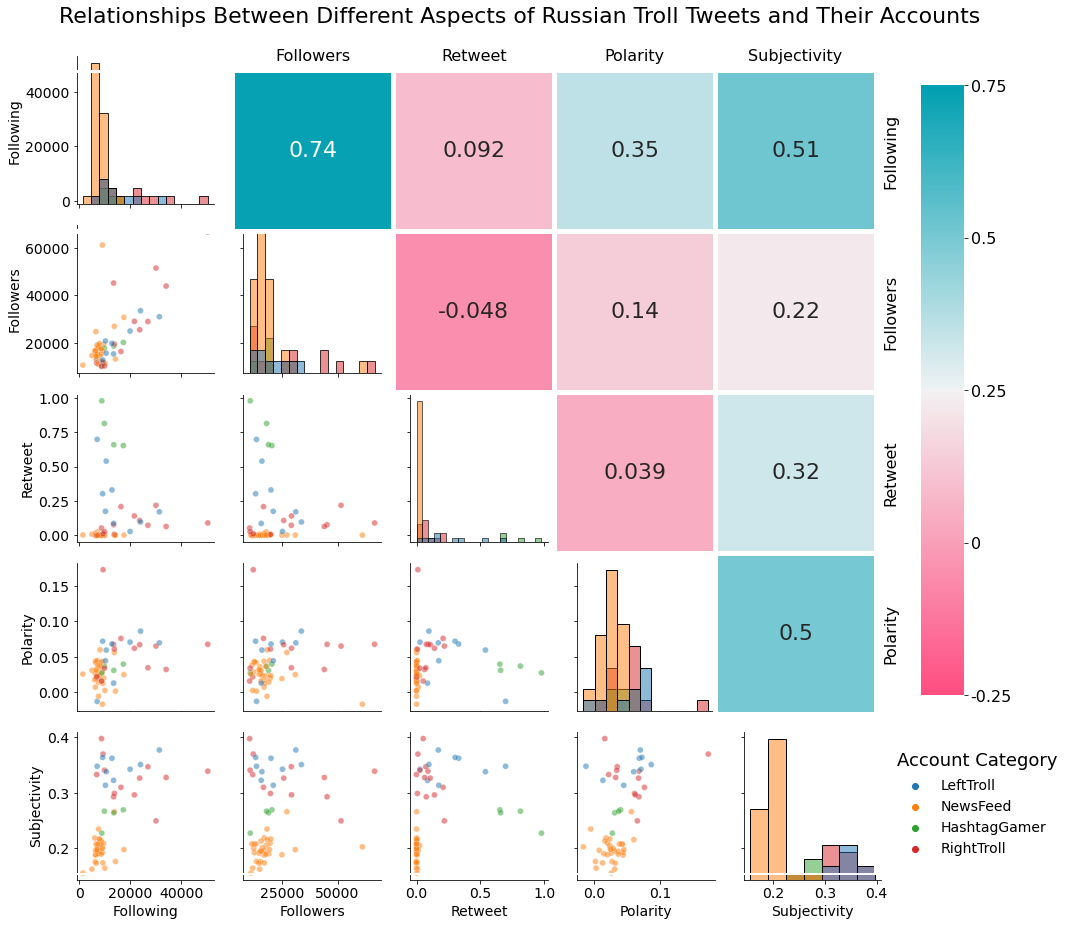

In [ ]:
# plot the data
fig=plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 14})

# pairgrid on the lower half of the figure
pg = sns.PairGrid(df_plot.drop(columns=col_to_drop), hue='account_category', diag_sharey=False)
pg.map_upper(hide_current_axis)
hp = pg.map_diag(sns.histplot)
pg.map_offdiag(sns.scatterplot, alpha=0.5)

pg.add_legend(title='', adjust_subtitles=True, bbox_to_anchor=(0.51, -0.119, .5, .5), 
            fontsize=14)
plt.text(.44, 16.2, 'Account Category   ', fontsize=18, weight='medium')

(xmin, _), (_, ymax) = pg.axes[0, 0].get_position().get_points()
(_, ymin), (xmax, _) = pg.axes[-1, -1].get_position().get_points()
ax1 = pg.fig.add_axes([xmin - 0.005, ymin - 0.005, xmax - xmin, ymax - ymin], facecolor='none')#, zorder=0)
ax2 = pg.fig.add_axes([0.88, 0.266, 0.04, 0.678], facecolor='none')

# heatmap on the upper half of the figure
ax_l = ['', 'Followers', 'Retweet', 'Polarity', 'Subjectivity']
ax2_l = ['Following', 'Followers', 'Retweet', 'Polarity', '']
cmap = sns.diverging_palette(0, 210, 100, 60, as_cmap=True)

hm = sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=0.75, vmin=-0.25, square=True,
                 linewidths=5, annot=True, annot_kws={'size': 22}, ax=ax1,
                 cbar=True, cbar_ax=ax2,
                 yticklabels=ax2_l, xticklabels=ax_l)

hm.tick_params(left=False, right=False, top=False, bottom=False, 
               labelleft=False, labelright=True, labeltop=True, labelbottom=False, 
               labelsize=16)
hm.set_yticklabels(hm.get_yticklabels(), va='center')

cbar = hm.collections[0].colorbar
cbar.set_ticks([-0.25, 0, 0.25, 0.5, 0.75])
cbar.set_ticklabels(['-0.25', '0', '0.25', '0.5', '0.75'])
cbar.ax.tick_params(labelsize=16)
cbar.outline.set_linewidth(0)
cbar.outline.set_edgecolor('white')

plt.suptitle('Relationships Between Different Aspects of Russian Troll Tweets and Their Accounts',
             fontsize=22, y=1.02, ha='center', va='center')

# plt.savefig('checkpoint.png', bbox_inches='tight', facecolor='w', dpi=800)
# plt.savefig('test.png', bbox_inches='tight', facecolor='w')

plt.show()

### Data Analysis

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We will read in the previously saved CSV file to start to analyze the data.

In [43]:
df = pd.read_csv('df_with_sentiment.csv')

We may want to consider looking only at tweets that have a non-zero polarity in the future, but this is not done in this analysis.

In [ ]:
# df = df[(df_eng.polarity != 0)   # filter out tweets with no polarity, not used in this analysis

In [44]:
df.account_category.value_counts()

NewsFeed        574694
RightTroll      497945
LeftTroll       416253
HashtagGamer    228105
Commercial      112051
Fearmonger       21838
Unknown           6165
NonEnglish        3555
Name: account_category, dtype: int64

We can see that there are still some 'NonEnglish' accounts, but their content is in English.

In [45]:
df[df.account_category == 'NonEnglish']

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category,polarity,subjectivity
15800,2.398931e+09,5EMEN5EMENICH,"World leaders, please wake up. #PutinPeacemake...",United States,English,9/28/2015 16:14,552,718,11196,RETWEET,Russian,1,NonEnglish,0.000000,0.000000
37258,2.186395e+09,AHMADYUSUFF03,Modern and perfect. http://t.co/8xxrOSwpag,United States,English,10/10/2015 7:28,8,0,1749,RETWEET,Arabic,1,NonEnglish,0.600000,0.650000
53357,2.425594e+09,ALENAZELDINA,Since the topic of children killed by Kiev eli...,United States,English,12/6/2015 20:12,411,216,5127,RETWEET,Russian,1,NonEnglish,0.150000,0.250000
53358,2.531597e+09,ALEXBORONIN,'@realDonaldTrump @megynkelly From Russia http...,United States,English,11/4/2015 13:30,431,371,675,RETWEET,Russian,1,NonEnglish,0.000000,0.000000
100580,2.252047e+09,ANASTASSIAZZ,Berlin calls for discussion of #Assad's future...,United States,English,1/2/2017 14:10,772,223,214,RETWEET,Russian,1,NonEnglish,0.000000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845532,2.260578e+09,YAROSLAVVELIKY,The Hillary Clinton Excuse Express rolls along...,United States,English,5/4/2017 2:06,83,4020,1705,RETWEET,Russian,1,NonEnglish,-0.050000,0.050000
1845533,2.260578e+09,YAROSLAVVELIKY,🆘‼️🛩🔥USA: Dashcam footage shows the moment a p...,United States,English,5/4/2017 8:07,83,4019,1708,RETWEET,Russian,1,NonEnglish,0.000000,1.000000
1849286,2.426557e+09,ZNATNIYBUKHARIK,"Followers - 337, Unfollowers - 97. I didn't kn...",United States,English,11/27/2015 11:37,1637,739,7016,RETWEET,Russian,1,NonEnglish,0.000000,0.357143
1849287,2.426557e+09,ZNATNIYBUKHARIK,"My week on Twitter: 96 New Followers, 1.43K Me...",United States,English,12/21/2015 13:40,1632,744,7178,RETWEET,Russian,1,NonEnglish,0.136364,0.454545


More importantly, we might want to dial down the number of account categories to analyze in order to get a clear understanding of the data.  
We will focus on the account categories that were analyzed in the [Linvill and Warren paper](http://pwarren.people.clemson.edu/Linvill_Warren_TrollFactory.pdf).

In [56]:
# filter out account categories not analysed in the Linvill & Warren paper
df_plot = df.loc[(df.account_category != 'NonEnglish')  & \
                 (df.account_category != 'Unknown')     & \
                 (df.account_category != 'Commercial')]   \
            .copy().reset_index(drop=True)

In [57]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1738835 entries, 0 to 1738834
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   external_author_id  float64
 1   author              object 
 2   content             object 
 3   region              object 
 4   language            object 
 5   publish_date        object 
 6   following           int64  
 7   followers           int64  
 8   updates             int64  
 9   post_type           object 
 10  account_type        object 
 11  retweet             int64  
 12  account_category    object 
 13  polarity            float64
 14  subjectivity        float64
dtypes: float64(3), int64(4), object(8)
memory usage: 199.0+ MB


We are still left with just under 1.75 million tweets. 

Let's take a quick look at the distributions of followers.

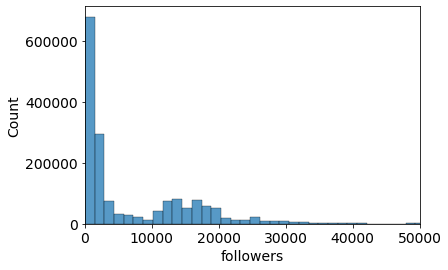

In [84]:
# IMPROVE THIS
sns.histplot(data=df_plot.followers, bins=100)
plt.xlim(0, 50000)
plt.show()

We can see that the vast majority of tweets were made by trolls with a follower count of less than 10,000.  

In order to analyze success in this analysis, we will be looking at the number of followers of the troll account.  
In this case, we are going to set 10,000 followers as the threshold for success.

We will also group the tweets by 'external_author_id' in order to avoid repeat counts of the same account.

In [88]:
MIN_FOLLOWERS = 10000           # somewhat arbitrary minimum follower count, 10,000 in this case to only analyse successful troll accounts
MAX_FOLLOWERS = float('inf')    # maximum number of followers to include in the analysis, may be specified later

# group by external_author_id in order to avoid repeat analysis of the same account
df_plot = df_plot.loc[(df_plot.followers > MIN_FOLLOWERS) & (df_plot.followers < MAX_FOLLOWERS)] \
                 .groupby('external_author_id').agg({'account_category': 'first',
                                                     'following':        np.mean,
                                                     'followers':        np.mean,
                                                     'updates':          np.mean,
                                                     'retweet':          np.mean,
                                                     'polarity':         np.mean,
                                                     'subjectivity':     np.mean}).reset_index()

In [93]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   external_author_id  58 non-null     float64
 1   account_category    58 non-null     object 
 2   following           58 non-null     float64
 3   followers           58 non-null     float64
 4   updates             58 non-null     float64
 5   retweet             58 non-null     float64
 6   polarity            58 non-null     float64
 7   subjectivity        58 non-null     float64
dtypes: float64(7), object(1)
memory usage: 3.8+ KB


This leaves us with 58 individual successful troll accounts. 

In [92]:
df_plot.head(3)

,external_author_id,account_category,following,followers,updates,retweet,polarity,subjectivity
0,1.687184e+09,LeftTroll,7010.135730,13221.878847,13667.435050,0.697117,-0.012913,0.347428
1,2.484643e+09,NewsFeed,7066.417235,17636.154758,1556.253142,0.024776,0.023272,0.204788
2,2.494112e+09,NewsFeed,6579.642109,12975.633762,16710.993953,0.001107,0.041540,0.207917


We can take a quick look at which account categories have the most successful accounts.

<AxesSubplot:>

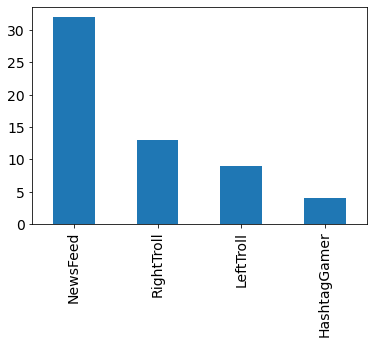

In [94]:
# IMPROVE THIS
df_plot.account_category.value_counts().plot(kind='bar')

### What characteristics of troll accounts and their tweets make them successful?

We can now analyze what is making these accounts successful.

We can create a correlation matrix to see how the number of followers and other characteristics of the account affect one another. 

In [95]:
# columns to not be included in the correlation matrix
col_to_drop = ['external_author_id', 'updates']

df_corr = df_plot.drop(columns=col_to_drop).copy().corr()
mask = np.tril(np.ones_like(df_corr, dtype=bool))

# working with the PairGrid to manually change labels is a pain, so changing it in the df
# df_plot.rename({'following':    'Following',
#                 'followers':    'Followers',
#                 'polarity':     'Polarity',
#                 'subjectivity': 'Subjectivity',
#                 'retweet':      'Retweet'}, axis='columns', inplace=True)

In [96]:
# Function used with PairGrid object
def hide_current_axis(*args, **kwargs):
    """Hides the current axis"""
    plt.gca().set_visible(False)

**Plot (1?):** Relationships Between Different Aspects of Successful Russian Troll Accounts and Their Tweets

<Figure size 864x864 with 0 Axes>

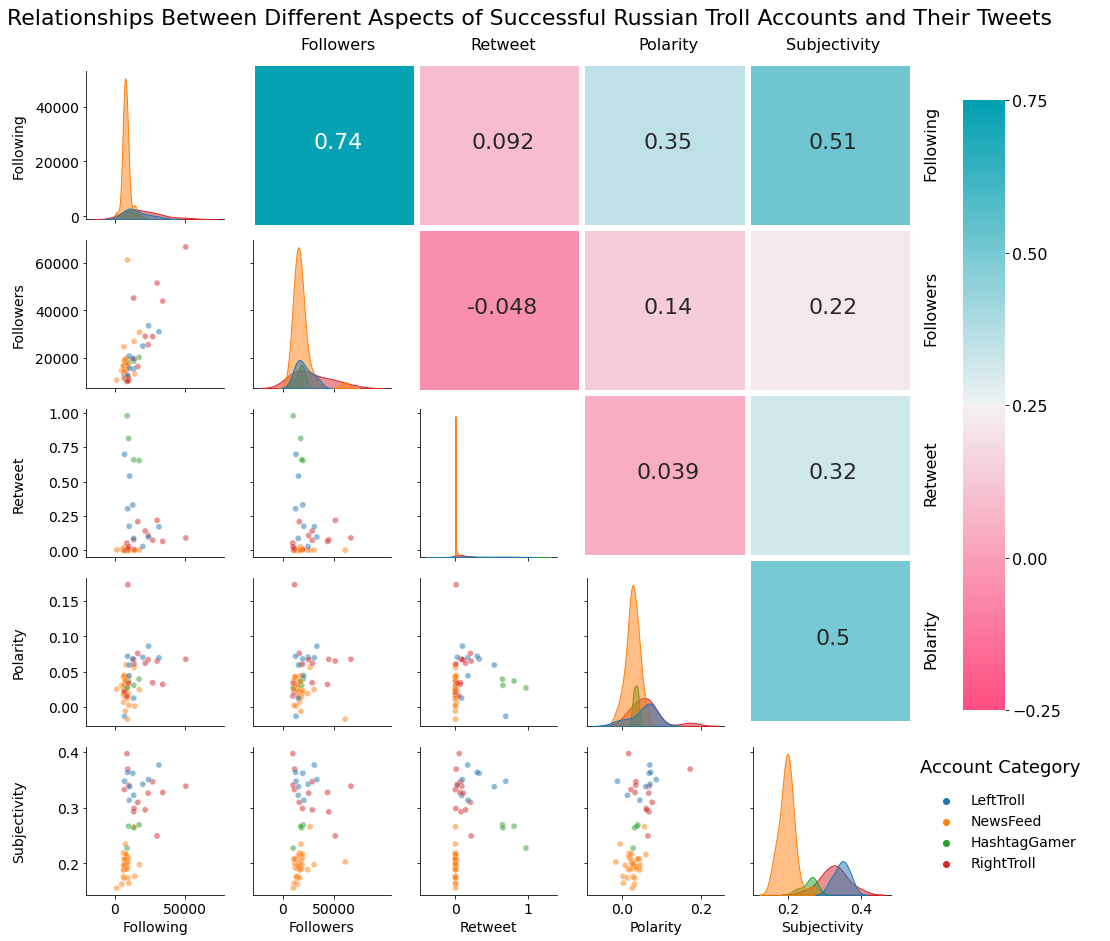

In [277]:
# create figure and set default font size
fig = plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 14})

# create pairgrid object
pg = sns.PairGrid(df_plot.drop(columns=col_to_drop), hue='account_category', diag_sharey=False)

# create new axis for heatmap and colorbar
(xmin, _), (_, ymax) = pg.axes[0, 0].get_position().get_points()
(_, ymin), (xmax, _) = pg.axes[-1, -1].get_position().get_points()
# ax1 = pg.fig.add_axes([xmin - 0.061, ymin - 0.003, xmax - xmin, ymax - ymin], facecolor='none')
# ax2 = pg.fig.add_axes([0.91, 0.266, 0.04, 0.678], facecolor='none')
ax1 = pg.fig.add_axes([xmin - 0.052, ymin + 0.01, xmax - xmin + 0.003, ymax - ymin + 0.003], facecolor='none')
ax2 = pg.fig.add_axes([0.91, 0.266, 0.04, 0.678], facecolor='none')

# create heatmap labels and colormap
ax1_labels = ['', 'Followers', 'Retweet', 'Polarity', 'Subjectivity']
ax2_labels = ['Following', 'Followers', 'Retweet', 'Polarity', '']
cmap = sns.diverging_palette(0, 210, 100, 60, as_cmap=True)

# create and edit heatmap and colorbar
hm = sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=0.75, vmin=-0.25, square=True,
                 linewidths=0, annot=True, annot_kws={'size': 22}, ax=ax1,
                 cbar=True, cbar_ax=ax2,
                 yticklabels=ax2_labels, xticklabels=ax1_labels)

hm.tick_params(left=False, right=False, top=False, bottom=False,
               labelleft=False, labelright=True, labeltop=True, labelbottom=False,
               labelsize=16)
hm.set_yticklabels(hm.get_yticklabels(), va='center')

cbar = hm.collections[0].colorbar
cbar.set_ticks([-0.25, 0, 0.25, 0.5, 0.75])
cbar.ax.tick_params(labelsize=16)
cbar.outline.set_linewidth(0)
cbar.outline.set_edgecolor('white')

# configure pairgrid object
pg.map_upper(hide_current_axis)
pg.map_diag(sns.kdeplot, legend=False, shade=True, alpha=0.5, linewidth=1, thresh=0)
pg.map_offdiag(sns.scatterplot, alpha=0.5)

# add a legend and legend title
pg.add_legend(title='', adjust_subtitles=True, bbox_to_anchor=(0.53, -0.119, .5, .5),
              fontsize=14)
plt.text(.56, 9.5, 'Account Category    ', fontsize=18, weight='medium')

# add linewidths to the heatmap manually
x_pos = [0.39, -0.06, -0.512, -0.962]
y_pos = [65.4, 52.6, 39.81, 27.05]
line_count = [23, 17, 12, 7]
for i in range(4):
    plt.text(0.55, y_pos[i], '_' * line_count[i], fontsize=60, weight='heavy', c='white', alpha=1, ha='right')
    plt.text(x_pos[i], 64.9, '_' * line_count[i], fontsize=60, weight='heavy', c='white', alpha=1, va='top', rotation=90)

# configure and edit labels
label_pads = [10, 10, 23, 23, 31.5]
axis_labels = ['Following', 'Followers', 'Retweet', 'Polarity', 'Subjectivity']

for idx, ax in enumerate(pg.axes.flat[0:21:5]):
    ax.set_ylabel(axis_labels[idx], labelpad=label_pads[idx], fontsize=14)

for idx, ax in enumerate(pg.axes.flat[:5]):
    ax.set_xlabel(axis_labels[idx])

for ax in pg.axes.flat[1:21:5]:
    ax.set_xticks([0, 50000])

plt.suptitle('Relationships Between Different Aspects of Successful Russian Troll Accounts and Their Tweets',
             fontsize=22, y=1.035, ha='center', va='center')

# plt.savefig('tweet_characteristics.png', bbox_inches='tight', facecolor='w', dpi=200)
# plt.savefig('tweet_characteristics.png', bbox_inches='tight', facecolor='w', dpi=800)

plt.show()

In [274]:
count = 0
for i in '_______________________':
    count += 1
    
count

23

In [266]:
# 65.2 - 52.4
52.8 - 12.8 - 12.8

27.2